In [1]:
### import libraries

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import torch.nn.functional as F
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython import display
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

display.set_matplotlib_formats('svg')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_47/3106972385.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
url = "/kaggle/input/heart-disease-health-indicators-dataset/heart_disease_health_indicators_BRFSS2015.csv"

data = pd.read_csv(url,sep=',')
print("Data Shape : ", data.shape)

Data Shape :  (253680, 22)


### Data Cleaning 

In [3]:
data.isnull().sum().to_frame()

,0
HeartDiseaseorAttack,0
HighBP,0
HighChol,0
CholCheck,0
BMI,0
Smoker,0
Stroke,0
Diabetes,0
PhysActivity,0
Fruits,0


In [4]:
print("Duplicate Values =", data.duplicated().sum())
data.drop_duplicates(inplace=True)
print("Duplicate Values =", data.duplicated().sum())
print("data shape :",data.shape)

Duplicate Values = 23899
Duplicate Values = 0
data shape : (229781, 22)


in the orginal,there were 253680 rows .

after removing duplicate, there are 229781 rows.

we removed 23899 rows.(229781+23899 = 253680)

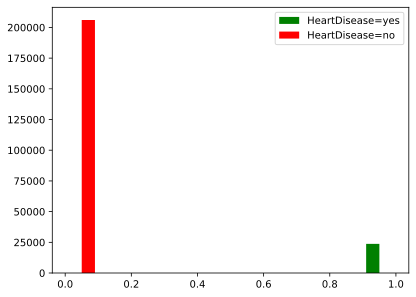

In [5]:
heart_disease_yes = data[data.HeartDiseaseorAttack == 1].HeartDiseaseorAttack
heart_disease_no = data[data.HeartDiseaseorAttack == 0].HeartDiseaseorAttack
plt.hist([ heart_disease_yes, heart_disease_no],color=["green", "red"], label=["HeartDisease=yes", "HeartDisease=no"])
plt.legend()

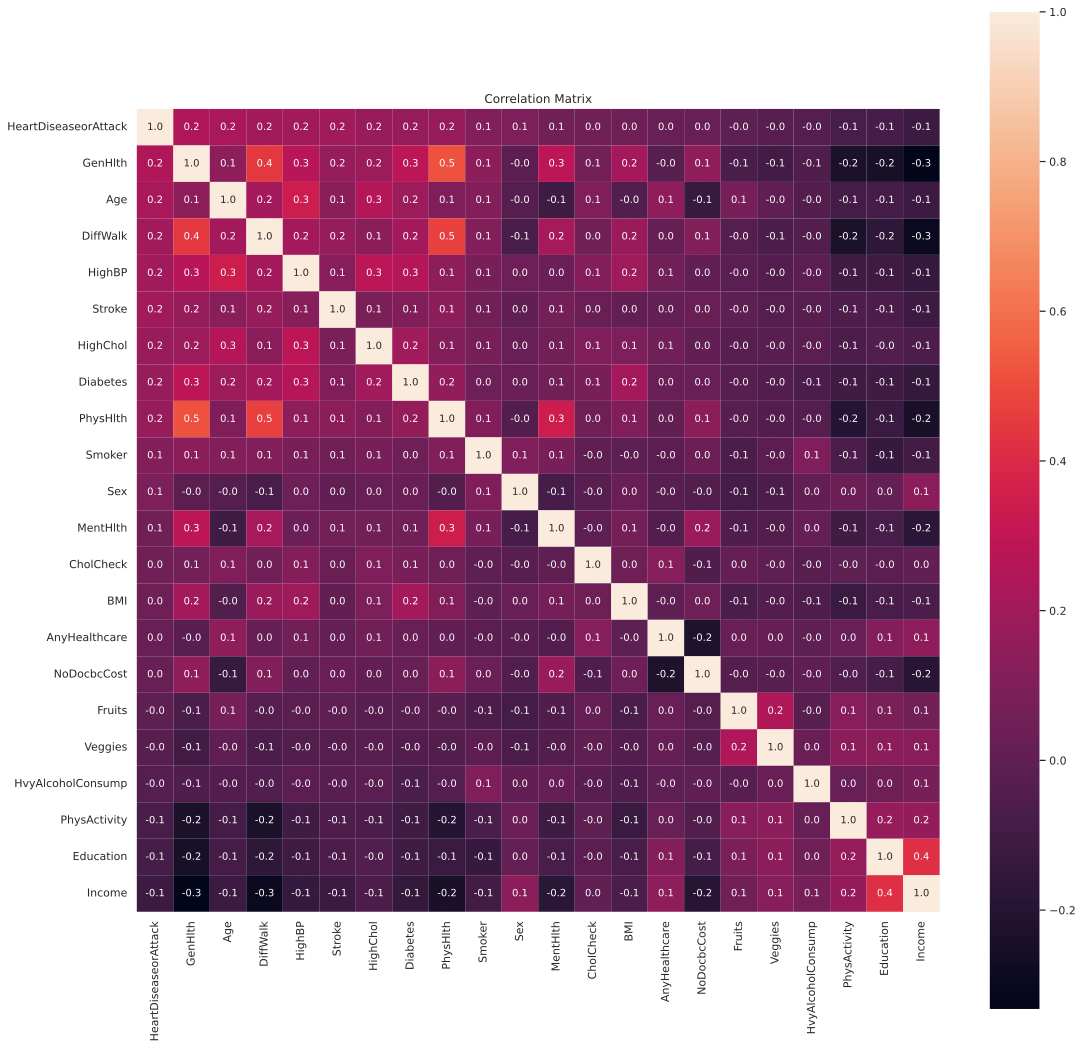

In [6]:
# correlation matrix
correlation_matrix = data.corr()
k = 22 # number of variables for heatmap
cols = correlation_matrix.nlargest(k,'HeartDiseaseorAttack')['HeartDiseaseorAttack'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(18,18))  # Sample figsize in inches
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.01f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,ax=ax)
plt.title("Correlation Matrix")
plt.show()

In [7]:
data.drop(columns=["Education", "Income", "PhysActivity" ,"Fruits" ,"Veggies", "AnyHealthcare" ], inplace=True)
print("data", data.shape)

data (229781, 16)


In [8]:
### z-score all variables except for quality

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('HeartDiseaseorAttack')

for col in cols2zscore:
  meanval   = np.mean(data[col]) 
  stdev     = np.std(data[col], ddof=1)
  data[col] = (data[col] - meanval) / stdev 

data.describe()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,HvyAlcoholConsump,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
count,229781.000000,2.297810e+05,2.297810e+05,2.297810e+05,2.297810e+05,2.297810e+05,2.297810e+05,2.297810e+05,2.297810e+05,2.297810e+05,2.297810e+05,2.297810e+05,2.297810e+05,2.297810e+05,2.297810e+05,2.297810e+05
mean,0.103216,9.946256e-17,-1.781142e-17,1.907306e-16,-2.270338e-16,7.062723e-17,4.100338e-17,4.808465e-18,4.762081e-18,1.422440e-17,2.523285e-17,8.281074e-17,-1.954309e-17,-1.170421e-17,3.178844e-17,-1.578290e-16
std,0.304241,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,-9.126774e-01,-8.895729e-01,-4.869584e+00,-2.458707e+00,-9.335237e-01,-2.164541e-01,-4.493749e-01,-2.542314e-01,-3.198509e-01,-1.503872e+00,-4.544332e-01,-5.167902e-01,-4.772387e-01,-8.850214e-01,-2.290569e+00
25%,0.000000,-9.126774e-01,-8.895729e-01,2.053555e-01,-6.904541e-01,-9.335237e-01,-2.164541e-01,-4.493749e-01,-2.542314e-01,-3.198509e-01,-5.646275e-01,-4.544332e-01,-5.167902e-01,-4.772387e-01,-8.850214e-01,-6.744381e-01
50%,0.000000,-9.126774e-01,-8.895729e-01,2.053555e-01,-2.483909e-01,-9.335237e-01,-2.164541e-01,-4.493749e-01,-2.542314e-01,-3.198509e-01,3.746171e-01,-4.544332e-01,-5.167902e-01,-4.772387e-01,-8.850214e-01,-2.798571e-02
75%,0.000000,1.095673e+00,1.124130e+00,2.053555e-01,4.883810e-01,1.071205e+00,-2.164541e-01,-4.493749e-01,-2.542314e-01,-3.198509e-01,3.746171e-01,-1.951551e-01,-7.463357e-02,-4.772387e-01,1.129911e+00,6.184666e-01
max,1.000000,1.095673e+00,1.124130e+00,2.053555e-01,1.021377e+01,1.071205e+00,4.619897e+00,2.310681e+00,3.933407e+00,3.126443e+00,2.253106e+00,3.434738e+00,2.799385e+00,2.095378e+00,1.129911e+00,1.588145e+00


In [9]:
# Convert from pandas DataFrame to tensor

dataT  = torch.tensor(data[cols2zscore].values).float()
print("dataT ==========>", dataT.shape)

labels = torch.tensor(data['HeartDiseaseorAttack'].values).float()
labels = labels[:, None]
print("lables =========>", labels.shape)

dataT ==========> torch.Size([229781, 15])
lables =========> torch.Size([229781, 1])


In [10]:
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.3)

sm = SMOTE(random_state=30, k_neighbors=5)
X_train_res, Y_train_res = sm.fit_resample(train_data, train_labels)

train_dataDataset = TensorDataset(torch.tensor(X_train_res), torch.tensor(Y_train_res[:, None]))
test_dataDataset  = TensorDataset(test_data,test_labels)


### Now for the DL part

In [11]:
class ANNHeartDiseasePredictionModel(nn.Module):
  def __init__(self, dropoutrate):
    super().__init__()
    self.dr = dropoutrate
    self.input = nn.Linear(15, 16)
    self.fc1 = nn.Linear(16, 16)
    self.bnorm1 = nn.BatchNorm1d(16)
    self.output = nn.Linear(16, 1)
  # Forward pass
  def forward(self, x, doBN):
    x = F.relu(self.input(x))
    if doBN:  
      x = F.dropout(x, p=self.dr, training=self.training)
      x = self.bnorm1(x)
      x = F.relu(self.fc1(x))
      x = F.dropout(x, p=self.dr, training=self.training)
    else:
      x = F.dropout(x, p=self.dr, training=self.training)
      x = F.relu(self.fc1(x))
      x = F.dropout(x, p=self.dr, training=self.training)
    return self.output(x)


In [12]:
def ANNHeartDiseaseModel(dropoutrate, learning_rate):
    
    custom_ann_model = ANNHeartDiseasePredictionModel(dropoutrate)

    loss_function = nn.BCEWithLogitsLoss()

    custom_optimizer = torch.optim.SGD(custom_ann_model.parameters(), lr=learning_rate)
    
    return custom_ann_model, loss_function, custom_optimizer


In [13]:

def TrainANNHeartDiseaseModel(custom_model, loss_function, custom_optimizer, num_epochs, train_loader, test_loader, doBN=True):
  
  training_losses = torch.zeros(num_epochs)
  trainAcc = []
  testAcc = []
  losses = []
  
  # Loop over epochs for training.
  for epoch in range(num_epochs):
      print("epoch Number", epoch)
      batchAcc = []  
      batchLoss = [] 
      
      for X, y in train_loader:  
        custom_model.train() 
      
        yHat = custom_model(X, doBN)

        loss = loss_function(yHat, y)
        training_losses[epoch] = loss

        custom_optimizer.zero_grad()
        loss.backward()
        custom_optimizer.step()
        
        batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
        batchLoss.append(loss.item())  

      trainAcc.append(np.mean(batchAcc))
      print("train acc", trainAcc[-1])
      losses.append(np.mean(batchLoss))
      print("losses", losses[-1]) 
      
      custom_model.eval() 
      
      X, y = next(iter(test_loader)) 
      
      with torch.no_grad():
        predlabels = torch.argmax(custom_model(X, doBN), axis=1) 
      testAcc.append(100 * torch.mean((predlabels == y).float()).item())  
      print("test Acc ", testAcc[-1])
      
  return trainAcc, testAcc, losses

In [14]:
dropoutrate = 0.3
learning_rate = 0.07
num_epochs = 50
batch_size = 5000

train_loader = DataLoader(train_dataDataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataDataset, batch_size=test_dataDataset.tensors[0].shape[0])

custom_ann_model, loss_function, custom_optimizer = ANNHeartDiseaseModel(dropoutrate, learning_rate)

trainAcc, testAcc, losses = TrainANNHeartDiseaseModel(custom_ann_model, loss_function, custom_optimizer, num_epochs, train_loader, test_loader, True)

print('Training Final accuracy: %g%%' % np.mean(trainAcc))
print('Testing Final accuracy: %g%%' % np.mean(testAcc))

epoch Number 0
train acc 50.004561271583825
losses 0.6671491348952577
test Acc  89.55682516098022
epoch Number 1
train acc 49.99999989543045
losses 0.6058982934868127
test Acc  89.55682516098022
epoch Number 2
train acc 50.00736844121364
losses 0.5666309344141107
test Acc  89.55682516098022
epoch Number 3
train acc 50.01298257133417
losses 0.5491575368663721
test Acc  89.55682516098022
epoch Number 4
train acc 50.00596490868351
losses 0.5404969307414272
test Acc  89.55682516098022
epoch Number 5
train acc 50.01122852166494
losses 0.5352008332285965
test Acc  89.55682516098022
epoch Number 6
train acc 49.99789433521137
losses 0.5309418283010784
test Acc  89.55682516098022
epoch Number 7
train acc 49.9996485940197
losses 0.5276099621203908
test Acc  89.55682516098022
epoch Number 8
train acc 50.000701452556406
losses 0.5256324368610716
test Acc  89.55682516098022
epoch Number 9
train acc 49.98947361059356
losses 0.5224775713786745
test Acc  89.55682516098022
epoch Number 10
train acc 50.

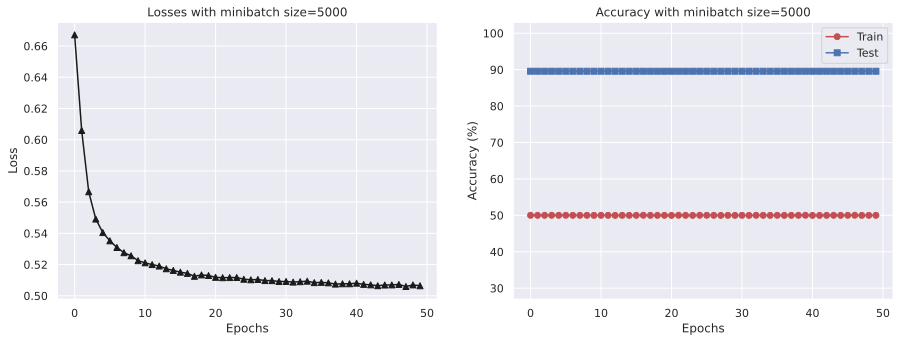

In [15]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batch_size))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batch_size))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])

plt.show()

# CrossValidation


In [17]:
#Cross Validation function.
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score



def crossValidation(fold,model_to_use,x,y,shuffle_value,random_state_value):
  # Initialize k-fold cross-validation
  k = fold
  kf = KFold(n_splits=k, shuffle=shuffle_value, random_state=random_state_value)

  # Lists to store evaluation metrics
  mse_scores = []
  accuracy_sum = 0
  accuracy_array = []
  i=1
  for train_index, test_index in kf.split(x):


      print(f"Fold {i} "+"=="*20)
      i+=1
      X_train, X_test = x[train_index], x[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # Fit the model
      model_to_use.fit(X_train, y_train)

      # Make predictions
      y_pred = model_to_use.predict(X_test)
      y_pred[y_pred < 0.5] = 0
      y_pred[y_pred >=0.5] = 1


      acc_val = accuracy_score(y_test, y_pred)
      print(acc_val)
      accuracy_sum += acc_val
      accuracy_array.append([acc_val])

      # Calculate mean squared error
      mse = mean_squared_error(y_test, y_pred)
      mse_scores.append(mse)

      print(f"-"*20)

  # Calculate average MSE across all folds
  average_mse = np.mean(mse_scores)
  average_acc = accuracy_sum/k
  print(f"Average Mean Squared Error: {average_mse:.4f}")
  print(f"accuracy Array : {accuracy_array}")
  print(f"average Accuracy: {average_acc}")


In [18]:
y = data['HeartDiseaseorAttack'].values
y =y.reshape(-1,1)
print( y.shape)


(229781, 1)


In [19]:
x = data.drop('HeartDiseaseorAttack',axis=1)
x = x.values

## MODEL DEFINE

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

In [23]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(15,)),
        Dense(15, activation='sigmoid', name = 'layer1'),
        Dense(16, activation='sigmoid', name = 'layer2'),
        Dense(16, activation='sigmoid', name = 'layer3'),
        Dense(1, activation='sigmoid', name = 'layer4'),
     ]
)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [24]:
model.fit(
    x,y,
    epochs=11,
)

Epoch 1/11
7181/7181 [==============================] - 32s 3ms/step - loss: 0.2624
Epoch 2/11
7181/7181 [==============================] - 24s 3ms/step - loss: 0.2591
Epoch 3/11
7181/7181 [==============================] - 24s 3ms/step - loss: 0.2587
Epoch 4/11
7181/7181 [==============================] - 24s 3ms/step - loss: 0.2583
Epoch 5/11
7181/7181 [==============================] - 23s 3ms/step - loss: 0.2579
Epoch 6/11
7181/7181 [==============================] - 23s 3ms/step - loss: 0.2578
Epoch 7/11
7181/7181 [==============================] - 23s 3ms/step - loss: 0.2576
Epoch 8/11
7181/7181 [==============================] - 23s 3ms/step - loss: 0.2575
Epoch 9/11
7181/7181 [==============================] - 23s 3ms/step - loss: 0.2574
Epoch 10/11
7181/7181 [==============================] - 23s 3ms/step - loss: 0.2573
Epoch 11/11
7181/7181 [==============================] - 23s 3ms/step - loss: 0.2572


In [25]:
#this model is used for reducing overfitting.
Regularized_model = Sequential(
    [
        tf.keras.Input(shape=(15,)),
        Dense(20, activation='sigmoid', name = 'layer1',kernel_regularizer=l2(0.01)),
        Dense(15, activation='sigmoid', name = 'layer2',kernel_regularizer=l2(0.01)),
        Dense(5, activation='sigmoid', name = 'layer3',kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid', name = 'layer4',kernel_regularizer=l2(0.01)),

     ]
)

Regularized_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [26]:
Regularized_model.fit(
    x,y,
    epochs=11,
)

Epoch 1/11
7181/7181 [==============================] - 26s 3ms/step - loss: 0.3385
Epoch 2/11
7181/7181 [==============================] - 24s 3ms/step - loss: 0.3322
Epoch 3/11
7181/7181 [==============================] - 24s 3ms/step - loss: 0.3322
Epoch 4/11
7181/7181 [==============================] - 25s 3ms/step - loss: 0.3323
Epoch 5/11
7181/7181 [==============================] - 25s 3ms/step - loss: 0.3322
Epoch 6/11
7181/7181 [==============================] - 25s 4ms/step - loss: 0.3322
Epoch 7/11
7181/7181 [==============================] - 25s 4ms/step - loss: 0.3322
Epoch 8/11
7181/7181 [==============================] - 25s 4ms/step - loss: 0.3322
Epoch 9/11
7181/7181 [==============================] - 24s 3ms/step - loss: 0.3322
Epoch 10/11
7181/7181 [==============================] - 26s 4ms/step - loss: 0.3322
Epoch 11/11
7181/7181 [==============================] - 25s 3ms/step - loss: 0.3322


### Standardizing the x_train data.

In [27]:
from sklearn.preprocessing import StandardScaler

scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
x_train = x
X_train_scaled = scaler_linear.fit_transform(x_train)


In [28]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    X_train_scaled,y,
    epochs=10,
)

Epoch 1/10
7181/7181 [==============================] - 25s 3ms/step - loss: 0.2570
Epoch 2/10
7181/7181 [==============================] - 24s 3ms/step - loss: 0.2569
Epoch 3/10
7181/7181 [==============================] - 23s 3ms/step - loss: 0.2572
Epoch 4/10
7181/7181 [==============================] - 23s 3ms/step - loss: 0.2571
Epoch 5/10
7181/7181 [==============================] - 23s 3ms/step - loss: 0.2569
Epoch 6/10
7181/7181 [==============================] - 24s 3ms/step - loss: 0.2569
Epoch 7/10
7181/7181 [==============================] - 23s 3ms/step - loss: 0.2569
Epoch 8/10
7181/7181 [==============================] - 23s 3ms/step - loss: 0.2567
Epoch 9/10
7181/7181 [==============================] - 23s 3ms/step - loss: 0.2569
Epoch 10/10
7181/7181 [==============================] - 24s 3ms/step - loss: 0.2569


In [29]:
# Using SMOTE for this data

In [30]:
sm = SMOTE(random_state=30, k_neighbors=5)
X_train_res, Y_train_res = sm.fit_resample(X_train_scaled, y)

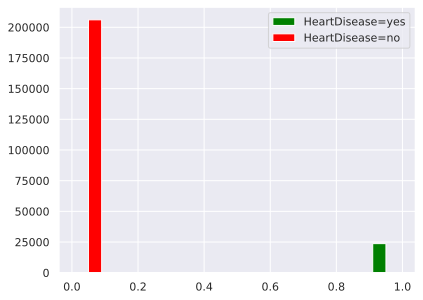

In [31]:
heart_disease_yes = data[data.HeartDiseaseorAttack == 1].HeartDiseaseorAttack
heart_disease_no = data[data.HeartDiseaseorAttack == 0].HeartDiseaseorAttack
plt.hist([ heart_disease_yes, heart_disease_no],color=["green", "red"], label=["HeartDisease=yes", "HeartDisease=no"])
plt.legend()

In [32]:
zero_count = np.count_nonzero(Y_train_res == 0)
one_count = np.count_nonzero(Y_train_res == 1)

In [33]:
print(zero_count,one_count)

206064 206064


In [34]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model_smote = Sequential(
    [
        tf.keras.Input(shape=(15,)),
        Dense(15, activation='relu', name = 'layer1'),
        Dense(16, activation='relu', name = 'layer2'),
        Dense(16, activation='relu', name = 'layer3'),
        Dense(1, activation='relu', name = 'layer4'),

     ]
)

model_smote.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)


In [35]:
#model crossvalidation using balanced dataset.
crossValidation(7,model_smote,X_train_res, Y_train_res,True,42)

Fold 1 ========================================
1840/1840 [==============================] - 3s 2ms/step
0.5032780759562471
--------------------
Fold 2 ========================================
1840/1840 [==============================] - 3s 2ms/step
0.4999490454514573
--------------------
Fold 3 ========================================
1840/1840 [==============================] - 3s 1ms/step
0.4987431211359467
--------------------
Fold 4 ========================================
1840/1840 [==============================] - 3s 1ms/step
0.5001104033970276
--------------------
Fold 5 ========================================
1840/1840 [==============================] - 3s 2ms/step
0.4991252653927813
--------------------
Fold 6 ========================================
1840/1840 [==============================] - 3s 1ms/step
0.49907430997876856
--------------------
Fold 7 ========================================
1840/1840 [==============================] - 3s 2ms/step
0.49971974522292995
----

In [36]:
#model crossvalidation using entire dataset(not normalized) without regularization.
crossValidation(7,model,x,y,True,42)

Fold 1 ========================================
1026/1026 [==============================] - 2s 1ms/step
0.8991652958021081
--------------------
Fold 2 ========================================
1026/1026 [==============================] - 2s 1ms/step
0.9005666240175471
--------------------
Fold 3 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.9005361603606897
--------------------
Fold 4 ========================================
1026/1026 [==============================] - 2s 1ms/step
0.8966063486260891
--------------------
Fold 5 ========================================
1026/1026 [==============================] - 2s 1ms/step
0.9005056967038323
--------------------
Fold 6 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.9010235788704076
--------------------
Fold 7 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.8961462300076162
------

In [37]:
#model crossvalidation using entire dataset(normalized) without regularization.
crossValidation(7,model,x,y,True,42)

Fold 1 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.8997745689392554
--------------------
Fold 2 ========================================
1026/1026 [==============================] - 1s 1ms/step
0.9003229147626881
--------------------
Fold 3 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.9007189423018339
--------------------
Fold 4 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.8965758849692317
--------------------
Fold 5 ========================================
1026/1026 [==============================] - 2s 1ms/step
0.9013282154389813
--------------------
Fold 6 ========================================
1026/1026 [==============================] - 2s 1ms/step
0.900810333272406
--------------------
Fold 7 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.8963290175171363
-------

In [38]:
#Regularization model crossvalidation using entire dataset with entire dataset(not normalized) with regularization.
crossValidation(7,model,x,y,True,42)

Fold 1 ========================================
1026/1026 [==============================] - 2s 1ms/step
0.8987692682629623
--------------------
Fold 2 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.9002619874489733
--------------------
Fold 3 ========================================
1026/1026 [==============================] - 2s 1ms/step
0.9006884786449766
--------------------
Fold 4 ========================================
1026/1026 [==============================] - 2s 1ms/step
0.8965149576555169
--------------------
Fold 5 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.9011758971546945
--------------------
Fold 6 ========================================
1026/1026 [==============================] - 2s 1ms/step
0.8999573508803996
--------------------
Fold 7 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.895993907083016
-------

In [39]:
#Regularization model crossvalidation using entire dataset with entire dataset(normalized) without regularization.
crossValidation(7,model,X_train_scaled,y,True,42)

Fold 1 ========================================
1026/1026 [==============================] - 2s 1ms/step
0.9000182781941144
--------------------
Fold 2 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.8995613233412539
--------------------
Fold 3 ========================================
1026/1026 [==============================] - 2s 1ms/step
0.9007189423018339
--------------------
Fold 4 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.8960580028026565
--------------------
Fold 5 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.9007189423018339
--------------------
Fold 6 ========================================
1026/1026 [==============================] - 2s 1ms/step
0.9002619874489733
--------------------
Fold 7 ========================================
1026/1026 [==============================] - 2s 2ms/step
0.896085300837776
-------